# MovieLens 1m Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-1m/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    min_rating,
    max_rating,
    mean_rating,
    n_latent,
    n_hidden_1,
    n_hidden_2,
    activation='relu',
    dropout_1=0.2,
    dropout_2=0.2,
    random_seed=42,
)
Docstring: <no docstring>
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

## 1. Number of latent factors and hidden nodes

In [11]:
from sklearn.model_selection import KFold

In [12]:
# hyper parameters
HP_N_FACTORS = [100, 200]
HP_N_HIDDEN_1 = [50, 100]
HP_N_HIDDEN_2 = [50, 100]

In [13]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting CGT model #{searches} with {N_FACTORS}: {N_HIDDEN_1} | {N_HIDDEN_2} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss = 0
            total_acc = 0
            count = 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items=df.movieId.nunique(),
                    n_users=df.userId.nunique(),
                    min_rating=df.rating.min(),
                    max_rating=df.rating.max(),
                    mean_rating=df.rating.mean(),
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    n_hidden_2=N_HIDDEN_2
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=2048,
                    epochs=8,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=128, 
                    epochs=5,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                fold_acc = np.max(result.history['val_accuracy'])
                total_acc += fold_acc
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                count += 1
                
                del model1, model2
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'val_epochs':min_epochs,
                                 'train_loss_hist':result.history['loss'],
                                 'val_loss_hist':result.history['val_loss'],
                                 'train_acc_hist':result.history['accuracy'],
                                 'val_acc_hist':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 8 models

Fitting CGT model #1 with 100: 50 | 50 architecture
_____________________________________CV avg val loss=0.7855
_____________________________________CV avg val acc=0.6543

Fitting CGT model #2 with 100: 50 | 100 architecture
_____________________________________CV avg val loss=0.7796
_____________________________________CV avg val acc=0.6690

Fitting CGT model #3 with 100: 100 | 50 architecture
_____________________________________CV avg val loss=0.7794
_____________________________________CV avg val acc=0.6726

Fitting CGT model #4 with 100: 100 | 100 architecture
_____________________________________CV avg val loss=0.7723
_____________________________________CV avg val acc=0.6774

Fitting CGT model #5 with 200: 50 | 50 architecture
_____________________________________CV avg val loss=0.7738
_____________________________________CV avg val acc=0.6792

Fitting CGT model #6 with 200: 50 | 100 architecture
_____________________________________CV avg val loss=0.7

In [14]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
7,200,100,100,0.758998,0.699850,5,"[0.6658482618596422, 0.6177019705658017, 0.593...","[0.638505601275271, 0.6063264757618196, 0.5903...","[0.6210645, 0.6656672, 0.6877811, 0.70052475, ...","[0.64167917, 0.6551724, 0.67616194, 0.68815595..."
6,200,100,50,0.767908,0.683658,5,"[0.6759135297749532, 0.6352291274285209, 0.612...","[0.6529185882751374, 0.6215374094435479, 0.604...","[0.583958, 0.66041976, 0.6690405, 0.68628186, ...","[0.63268363, 0.65217394, 0.6596702, 0.66866565..."
5,200,50,100,0.768864,0.680060,5,"[0.6644237584796088, 0.6233440679588775, 0.607...","[0.6389930853243174, 0.6116214541123546, 0.597...","[0.6105697, 0.65442276, 0.6649175, 0.68028486,...","[0.63568217, 0.6431784, 0.6596702, 0.6656672, ..."
3,100,100,100,0.772298,0.677361,5,"[0.670056258631253, 0.6327832238427524, 0.6152...","[0.6431438899647886, 0.6137962688034263, 0.601...","[0.62406296, 0.65667164, 0.6634183, 0.67241377...","[0.64467764, 0.64767617, 0.65817094, 0.6641679..."
4,200,50,50,0.773837,0.679160,5,"[0.6734091180196587, 0.6356052449796868, 0.618...","[0.652787916842608, 0.6237819660371211, 0.6078...","[0.59145427, 0.6596702, 0.66641676, 0.67466265...","[0.6041979, 0.62968516, 0.6371814, 0.64467764,..."
2,100,100,50,0.779423,0.672564,5,"[0.6808526919878226, 0.6503089368790165, 0.631...","[0.6629162259187655, 0.6349369250852307, 0.616...","[0.5783358, 0.65404797, 0.6589205, 0.666042, 0...","[0.61769116, 0.64617693, 0.65067464, 0.6476761..."
1,100,50,100,0.779597,0.668966,5,"[0.666096854603094, 0.6338179560079389, 0.6217...","[0.6414989175825104, 0.6179993579770136, 0.608...","[0.6195652, 0.65254873, 0.65817094, 0.67053974...","[0.63268363, 0.63568217, 0.64467764, 0.6626686..."
0,100,50,50,0.785459,0.654273,5,"[0.6863045822912786, 0.658644362814959, 0.6397...","[0.6710968140004456, 0.6448245221885784, 0.625...","[0.5468516, 0.63005996, 0.6431784, 0.6495502, ...","[0.6146926, 0.63418293, 0.63868064, 0.6431784,..."


In [15]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

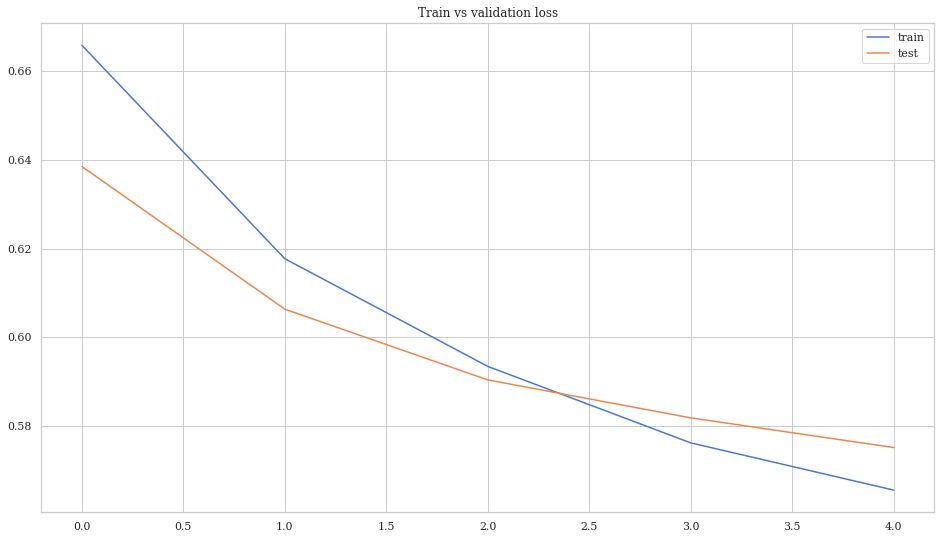

In [16]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

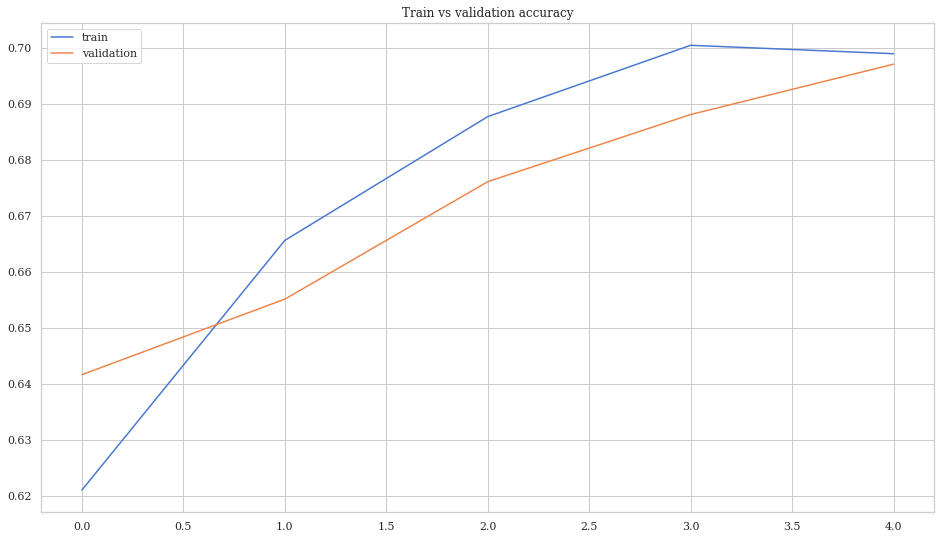

In [17]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [18]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors     200
n_hidden_1    100
n_hidden_2    100
Name: 7, dtype: object

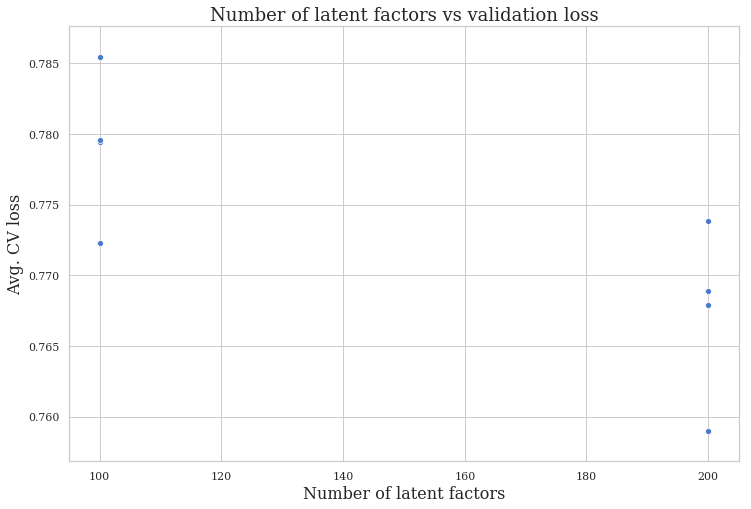

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='n_factors',
                y='val_loss',
#                 hue='n_hidden_2',
#                 size='n_hidden_2',
#                 palette='Set3',
                data=grid_results)

plt.title('Number of latent factors vs validation loss', fontsize=18)
plt.xlabel('Number of latent factors', fontsize=16)
plt.ylabel('Avg. CV loss', fontsize=16)
plt.savefig('figures/ml_100k_latent_factors.pdf', bbox_inches='tight')
# plt.legend(title='Hidden layer in genre model')
plt.show()

## 2. Dropout rates

In [20]:
# hyper parameters
HP_DROPOUT_1 = [.15, .2, .25]
HP_DROPOUT_2 = [.15, .2, .25]

In [21]:
# dataframe to store results of grid search
grid_results_2 = []
searches = 1

n_models = len(HP_DROPOUT_1) * len(HP_DROPOUT_2)

print(f'Fitting total of {n_models} models\n')

for DROPOUT_1 in HP_DROPOUT_1:
    for DROPOUT_2 in HP_DROPOUT_2:

        print(f'Fitting CGT model #{searches} with dr1: {DROPOUT_1} | dr2: {DROPOUT_2}')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1
        min_epochs = 10

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index)

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=best_rating_hparams.n_factors, 
                n_hidden_1=best_rating_hparams.n_hidden_1,
                n_hidden_2=best_rating_hparams.n_hidden_2,
                dropout_1=DROPOUT_1,
                dropout_2=DROPOUT_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=2048,
                epochs=8,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=128, 
                epochs=5,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = np.sqrt(np.min(result.history['val_loss']))
            total_loss += fold_loss
            fold_acc = np.max(result.history['val_accuracy'])
            total_acc += fold_acc
            min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)

            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results_2.append({'dropout_1':DROPOUT_1,
                               'dropout_2':DROPOUT_2,
                               'val_loss':avg_loss,
                               'val_acc':avg_acc,
                               'val_epochs':min_epochs,
                               'train_loss_hist':result.history['loss'],
                               'val_loss_hist':result.history['val_loss'],
                               'train_acc_hist':result.history['accuracy'],
                               'val_acc_hist':result.history['val_accuracy']})

        print()
#             break
#         break
    
col_order = grid_results_2[0].keys()

# save results to data frame
grid_results_2 = pd.DataFrame(grid_results_2)
# reorder columns
grid_results_2 = grid_results_2[col_order]

Fitting total of 9 models

Fitting CGT model #1 with dr1: 0.15 | dr2: 0.15
_____________________________________CV avg val loss=0.7554
_____________________________________CV avg val acc=0.7043

Fitting CGT model #2 with dr1: 0.15 | dr2: 0.2
_____________________________________CV avg val loss=0.7557
_____________________________________CV avg val acc=0.7025

Fitting CGT model #3 with dr1: 0.15 | dr2: 0.25
_____________________________________CV avg val loss=0.7559
_____________________________________CV avg val acc=0.7004

Fitting CGT model #4 with dr1: 0.2 | dr2: 0.15
_____________________________________CV avg val loss=0.7587
_____________________________________CV avg val acc=0.7004

Fitting CGT model #5 with dr1: 0.2 | dr2: 0.2
_____________________________________CV avg val loss=0.7590
_____________________________________CV avg val acc=0.6999

Fitting CGT model #6 with dr1: 0.2 | dr2: 0.25
_____________________________________CV avg val loss=0.7592
______________________________

In [22]:
# get best 5 models
grid_results_2 = grid_results_2.sort_values('val_loss')
grid_results_2.to_csv(path+'grid_results_2.csv', index=False)

grid_results_2.head(5)

,dropout_1,dropout_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
0,0.15,0.15,0.755377,0.704348,5,"[0.6645117125947257, 0.6137002870060694, 0.587...","[0.637884573511098, 0.604546748090541, 0.58687...","[0.6285607, 0.67691153, 0.6930285, 0.70727134,...","[0.6551724, 0.66266865, 0.68215895, 0.70014995..."
1,0.15,0.20,0.755662,0.702549,5,"[0.6645956792752782, 0.6146208145271713, 0.588...","[0.6383739671428343, 0.6049560616756308, 0.587...","[0.6244378, 0.67391306, 0.69415295, 0.70689654...","[0.6551724, 0.66266865, 0.68065965, 0.6956522,..."
2,0.15,0.25,0.755900,0.700450,5,"[0.6655952825002942, 0.6153417920422876, 0.589...","[0.6393502367132607, 0.6057496363076492, 0.587...","[0.61806595, 0.6754123, 0.6934033, 0.7050225, ...","[0.6536732, 0.66266865, 0.6776612, 0.69415295,..."
6,0.25,0.15,0.757716,0.703748,5,"[0.6642720785098097, 0.6147861622798926, 0.591...","[0.6376128076077222, 0.6051754996158194, 0.588...","[0.6278111, 0.6791604, 0.68665665, 0.7050225, ...","[0.6431784, 0.6596702, 0.67616194, 0.6896552, ..."
7,0.25,0.20,0.758015,0.703148,5,"[0.6644458233684614, 0.6156729085334595, 0.592...","[0.6382043982731707, 0.6056152405231253, 0.589...","[0.6255622, 0.67653674, 0.68290854, 0.70464766...","[0.64467764, 0.6611694, 0.6716642, 0.68665665,..."


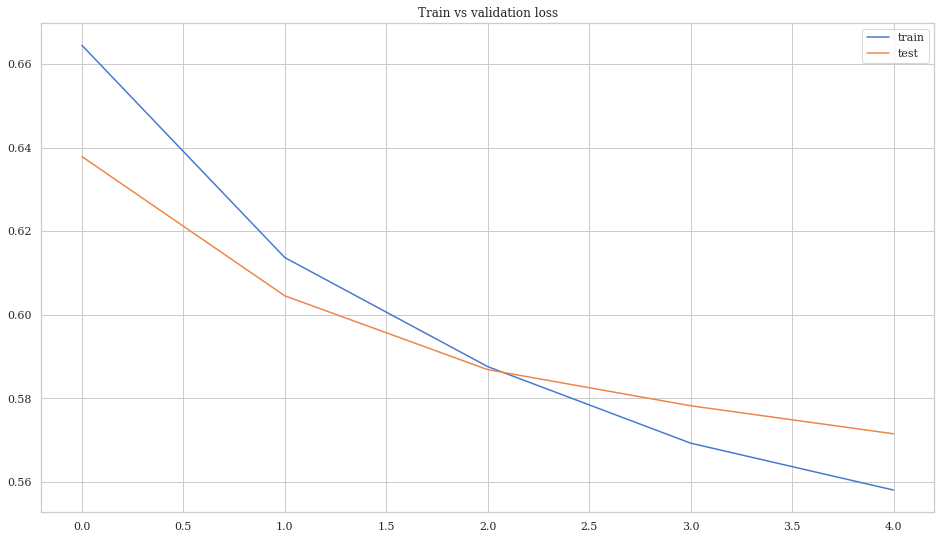

In [23]:
# plot training curve of best model
plt.plot(grid_results_2.train_loss_hist.values[0], label='train')
plt.plot(grid_results_2.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

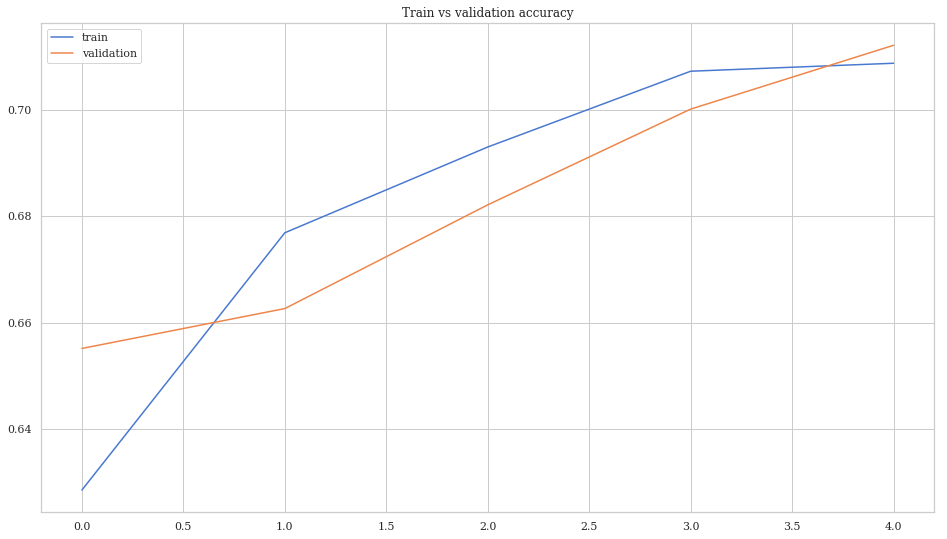

In [24]:
# train vs test accuracy
plt.plot(grid_results_2.train_acc_hist.values[0], label='train')
plt.plot(grid_results_2.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [25]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_2.iloc[0,:][['dropout_1', 'dropout_2']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
dropout_1     0.15
dropout_2     0.15
dtype: object

## 3. Activation function

In [26]:
# hyper parameters
HP_ACTIVATION = [None, 'relu', 'selu', 'softplus', 'tanh']

In [27]:
# dataframe to store results of grid search
grid_results_3 = []
searches = 1

n_models = len(HP_ACTIVATION)

print(f'Fitting total of {n_models} models\n')

for ACTIVATION in HP_ACTIVATION:

    print(f'Fitting CGT model #{searches} with {ACTIVATION}')
    searches += 1

    # Create 5 CV folds
    kf = KFold(n_splits=5, random_state=42)

    # initialise loss and epoch count
    total_loss = 0
    total_acc = 0
    count = 1
    min_epochs = 10

    # do CV split and compute baseline predictors each time
    for train_index, test_index in kf.split(movies):

        # get baseline rating predictors for full dataset
        train, _, _ = get_baseline(df, df.index, df.index)

        # compile both models with search hparams
        model1, model2 = compile_genre_model(
            n_items=df.movieId.nunique(),
            n_users=df.userId.nunique(),
            min_rating=df.rating.min(),
            max_rating=df.rating.max(),
            mean_rating=df.rating.mean(),
            n_latent=best_rating_hparams.n_factors, 
            n_hidden_1=best_rating_hparams.n_hidden_1,
            n_hidden_2=best_rating_hparams.n_hidden_2,
            dropout_1=best_rating_hparams.dropout_1,
            dropout_2=best_rating_hparams.dropout_1,
            activation=ACTIVATION
        )

        # train rating model on all data
        ratings = model1.fit(
            x=[train.userId.values, train.movieId.values, train.bias.values],
            y=train.rating.values, 
            batch_size=2048,
            epochs=8,
            verbose=0,
            validation_split=.2
        )

        # train genre model on 5 CV folds
        train = movies.iloc[train_index]
        test = movies.iloc[test_index]

        # train model on current fold
        result = model2.fit(
            train.movieId.values, train.Drama.values,
            batch_size=128, 
            epochs=5,
            verbose=0,
            validation_data=(test.movieId.values, test.Drama.values))

        # get loss from this fold
        fold_loss = np.sqrt(np.min(result.history['val_loss']))
        total_loss += fold_loss
        fold_acc = np.max(result.history['val_accuracy'])
        total_acc += fold_acc
        min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)

        count += 1

        del model1, model2

    # calculate average holdout loss across all CV folds
    avg_loss = total_loss / 5
    avg_acc = total_acc / 5
    print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
    print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

    grid_results_3.append({'activation':ACTIVATION,
                           'val_loss':avg_loss,
                           'val_acc':avg_acc,
                           'val_epochs':min_epochs,
                           'train_loss_hist':result.history['loss'],
                           'val_loss_hist':result.history['val_loss'],
                           'train_acc_hist':result.history['accuracy'],
                           'val_acc_hist':result.history['val_accuracy']})

    print()
    
col_order = grid_results_3[0].keys()

# save results to data frame
grid_results_3 = pd.DataFrame(grid_results_3)
# reorder columns
grid_results_3 = grid_results_3[col_order]

Fitting total of 5 models

Fitting CGT model #1 with None
_____________________________________CV avg val loss=0.7978
_____________________________________CV avg val acc=0.6252

Fitting CGT model #2 with relu
_____________________________________CV avg val loss=0.7554
_____________________________________CV avg val acc=0.7043

Fitting CGT model #3 with selu
_____________________________________CV avg val loss=0.7900
_____________________________________CV avg val acc=0.6459

Fitting CGT model #4 with softplus
_____________________________________CV avg val loss=0.7906
_____________________________________CV avg val acc=0.6390

Fitting CGT model #5 with tanh
_____________________________________CV avg val loss=0.7977
_____________________________________CV avg val acc=0.6270



In [28]:
# get best 5 models
grid_results_3 = grid_results_3.sort_values('val_loss')
grid_results_3.to_csv(path+'grid_results_3.csv', index=False)

grid_results_3.head(5)

,activation,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
1,relu,0.755377,0.704348,5,"[0.6645117125947257, 0.6137002870060694, 0.587...","[0.637884573511098, 0.604546748090541, 0.58687...","[0.6285607, 0.67691153, 0.6930285, 0.70727134,...","[0.6551724, 0.66266865, 0.68215895, 0.70014995..."
2,selu,0.790017,0.645877,1,"[0.6476675663394728, 0.6267622187398542, 0.621...","[0.6287668382209995, 0.6183473130037402, 0.615...","[0.6150675, 0.64392805, 0.65217394, 0.6615442,...","[0.62068963, 0.6221889, 0.64167917, 0.63268363..."
3,softplus,0.790610,0.638981,1,"[0.6646523339816298, 0.6420770440323242, 0.651...","[0.6209516029307868, 0.6299523813077534, 0.623...","[0.5892054, 0.62668663, 0.6109445, 0.62968516,...","[0.6431784, 0.62668663, 0.6371814, 0.63868064,..."
4,tanh,0.797688,0.626987,1,"[0.654899469469262, 0.6384564138602639, 0.6357...","[0.6386163537648843, 0.629594859601497, 0.6283...","[0.6090705, 0.6248126, 0.6248126, 0.6289355, 0...","[0.6041979, 0.6071964, 0.61169416, 0.61169416,..."
0,None,0.797803,0.625187,1,"[0.6520172349516599, 0.6377849425154289, 0.635...","[0.6385477839381263, 0.6296193944639352, 0.628...","[0.60382307, 0.6225637, 0.6281859, 0.6304348, ...","[0.5982009, 0.61169416, 0.6086956, 0.6161919, ..."


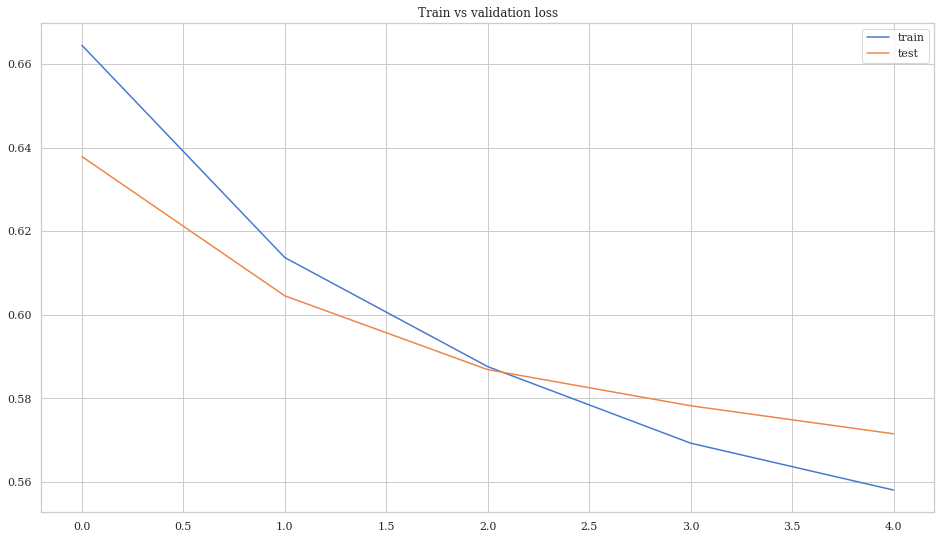

In [29]:
# plot training curve of best model
plt.plot(grid_results_3.train_loss_hist.values[0], label='train')
plt.plot(grid_results_3.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

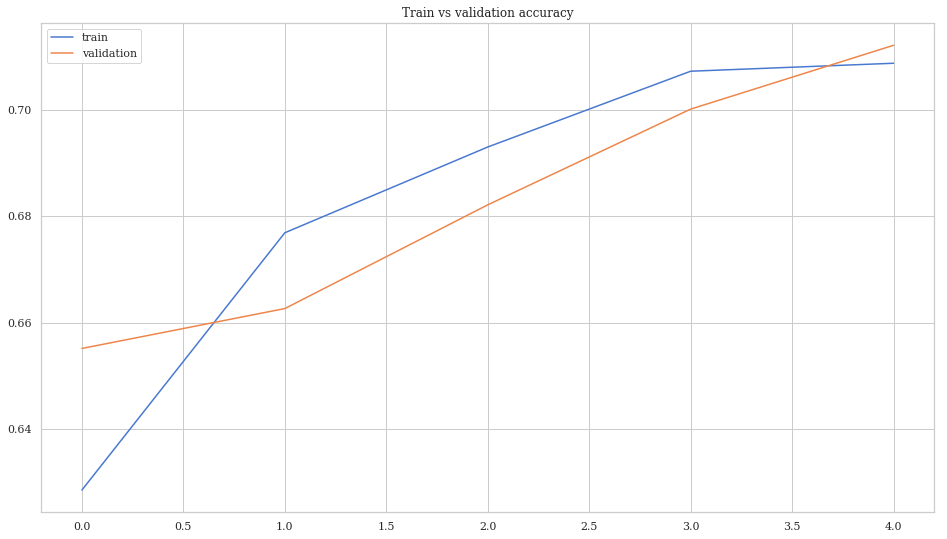

In [30]:
# train vs test accuracy
plt.plot(grid_results_3.train_acc_hist.values[0], label='train')
plt.plot(grid_results_3.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [31]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_3.iloc[0,:][['activation']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
dropout_1     0.15
dropout_2     0.15
activation    relu
dtype: object

# Classification report

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [33]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=best_rating_hparams.dropout_1,
    dropout_2=best_rating_hparams.dropout_1,
    activation=best_rating_hparams.activation
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=8,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=5,
    validation_split=.2)

Train on 800167 samples, validate on 200042 samples
Epoch 1/8
800167/800167 [==============================] - 84s 105us/sample - loss: 0.8118 - val_loss: 0.8738
Epoch 2/8
800167/800167 [==============================] - 84s 105us/sample - loss: 0.7623 - val_loss: 0.8750
Epoch 3/8
800167/800167 [==============================] - 85s 107us/sample - loss: 0.7323 - val_loss: 0.8785
Epoch 4/8
800167/800167 [==============================] - 87s 108us/sample - loss: 0.7023 - val_loss: 0.8823
Epoch 5/8
800167/800167 [==============================] - 87s 108us/sample - loss: 0.6751 - val_loss: 0.8861
Epoch 6/8
800167/800167 [==============================] - 86s 108us/sample - loss: 0.6518 - val_loss: 0.8902
Epoch 7/8
800167/800167 [==============================] - 87s 108us/sample - loss: 0.6303 - val_loss: 0.8922
Epoch 8/8
800167/800167 [==============================] - 87s 108us/sample - loss: 0.6114 - val_loss: 0.9058
Train on 2668 samples, validate on 667 samples
Epoch 1/5
2668/2668 [

### Evaluate on test set

In [34]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       227
           1       0.64      0.61      0.62       144

    accuracy                           0.71       371
   macro avg       0.70      0.70      0.70       371
weighted avg       0.71      0.71      0.71       371



In [36]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,177,50
1,56,88
